In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-hxbmrw0y
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-hxbmrw0y
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=364e66af1dcf12560b725ae5a17f05e3612abdcf23c2d01354fe7dd5329d1505
  Stored in directory: /tmp/pip-ephem-wheel-cache-xtlmw2ra/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 8.7MB/s 


In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-uiyl8b16
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-uiyl8b16
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=8dd4f8333635cf13bada277479465cb1f4099cbe82801da0af502aed610b55fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-8c88mrdv/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
import zipfile
import shutil 
import os
from time import time
from datetime import datetime as dt

from matplotlib import pyplot as plt
import numpy as np
import random
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
from keras import Model


from mtcnn.mtcnn import MTCNN

from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Funzioni

In [ ]:
# funzione per visualizzare piu immagini insieme
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)
  
  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1


def get_model_summary(model, layers_to_display = []):

  # stampa solo il summary dei layers indicati (+ pulito)


  # se la lista e' vuota stampo tutto
  if not len(layers_to_display):
    layers_to_display = [x for x in range(len(model.layers))]
  
  print('Layer name\t', 'Output shape',)
  
  for i in layers_to_display:
    
    layer = model.layers[i]
    print(layer.name,'\t', layer.output_shape)

In [ ]:
# feature extraction da modelli preaddestrati
def neural_features(img, net = None, prep_fun = None):

    x = kimage.img_to_array(img)
    
    # se no rete e no preprocessing non faccio niente
    if (net == None) & (prep_fun == None): 
      return x.flatten()
    
    elif prep_fun != None:

      # preprocessing
      x = prep_fun(x)
    
    x = np.expand_dims(x, axis=0)
    
    # estrazione features
    f = net.predict(x)
    return f.flatten()

# Data loader
def load_data(net = None, prep_fun = None, target_size = (224, 224)):
  base_path = '/content/thumbnails_features_deduped_publish/'

  paths = []
  features = []

  # lista percorsi immagini
  list_vip_image = [ 
                    base_path + folder + '/' + fname for folder in os.listdir(base_path) 
                    for fname in os.listdir(base_path+folder)
                    ]
  for fi,f in enumerate(sorted(list_vip_image)):
    
    if fi%10000 == 0:
        print(fi)
    
    if f.endswith('.jpg'):
      
      # lista percorsi
      paths.append(f)
            
      # lettura immagine e estrazione features
      image = kimage.load_img(f, target_size = target_size)
      cur_features = neural_features(image, net, prep_fun)
      features.append(cur_features)
      
  features = np.array(features)
  
  return features, paths

In [ ]:
def face_cropper_cv2(image, target_size = (224,224), detector = "haarcascade_frontalface_default.xml"):

  # face cropper di cv2


  model = cv2.CascadeClassifier(xml_model)
  
  # array di bounding boxes
  bboxes = model.detectMultiScale(
      image,
      scaleFactor = 1.2,
      minNeighbors = 3,
      minSize = (15,15),
      flags = cv2.CASCADE_SCALE_IMAGE
      )
  
  # elenco bboxes
  cropped_list = []
  for x, y, w, h in bboxes:
    
    cropped_img = image[y:y+h,x:x+w]
    cropped_img = cv2.resize(cropped_img, (160, 160), cv2.INTER_CUBIC)
    cropped_list.append(cropped_img)

  return cropped_list

def cropp_data(limit = None, cropping = False, detector = None):

  # data loader che ritaglia i volti dalle immagini 


  base_path = '/content/thumbnails_features_deduped_publish/'
  
  paths = []
  images = []

  list_vip_image = [ 
                    base_path + folder + '/' + fname
                    for folder in sorted(os.listdir(base_path))[:limit]
                    for fname in random.sample(
                        os.listdir(base_path+folder),
                        min(20,len(os.listdir(base_path+folder))))
                    ]
  for fi,f in enumerate(sorted(list_vip_image)):
    
    if fi%10000 == 0:
        print(fi)
    
    
    if f.endswith('.jpg'):
      
      # memorizzo percorso
      paths.append(f)
            
      # lettura immagine
      image = cv2.imread(f)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # se non funziona il cropping mantengo l'immagine originale
      if cropping:
        try:
          image = cropping(image, detector = detector)
        except:
          pass

      images.append(image)
  
  return images, paths

In [ ]:
def face_cropper_mtcnn(image, detector):

  # bbox regression con mtcnn


  # predict dei bboxes, l'output e' una lista di dizionari,
  # ogni dizionario ha come chiave 'box' che contiene le coordinate del
  # box (x, y, width, height)
  # oltre ai punti chiave tipo occhi e naso..
  faces = detector.detect_faces(image)

  # itero sui volti identificati
  cropped_list = []
  for face in faces:
    x, y, w, h = face['box']
    cropped_img = image[y:y+h,x:x+w]
    #cropped_img = cv2.resize(cropped_img, target_size, cv2.INTER_CUBIC)
    cropped_list.append(cropped_img)

  if not np.prod(cropped_list[0].shape):
    cropped_list = [image]
  return cropped_list[0]


def features_cropped_images(images, paths, net = None, prep_fun = None, target_size = (224,224)):

  # estrazione feature su immagini con volto ritagliato
  failed_cropped_path = []
  cropped_path = []
  x = []
  i = 0
  for img in images:
    print(paths[i])
    # se va in errore il resize (riquadro con alezza nulla) inserisco fra i fail
    try:
      img = cv2.resize(img, target_size, cv2.INTER_CUBIC)
      if prep_fun:
        img = prep_fun(img)
      img = np.expand_dims(img, 0).astype('float16')
      
      x.append(img)
      cropped_path.append(paths[i])
    except:
      failed_cropped_path.append(paths[i])
    if i%1000 == 0:
      print(i)
    i+=1

  f = np.concatenate(x,0)
  if net:
    f = net.predict(f).astype('float16')
  
  return f, cropped_path, failed_cropped_path




def retrieval_cropping(paths, query_path, tree, net, prep_function, num_image, target_size = (244,244), cropping = False, detector = None):

  # immagine di query
  query_image = cv2.imread(query_path)
  
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

  # cropping se previsto
  cropped = query_image.copy()
  if cropping:
    cropped = face_cropper_mtcnn(cropped, detector = detector)
  else:
    cropped = cv2.resize(query_image, target_size)

  # estrazione features
  query_features, query_paths, query_fail = features_cropped_images(
      [cropped],
      [query_path],
      net,
      prep_function,
      target_size = target_size
      )
  
  # best k images
  dist, ind = tree.query(query_features, k = num_image)
  print(ind)
  for i in range(0, num_image):

    print(paths[ind[0][i]])
    print(dist[0][i])
    # immagine corrente
    matching = cv2.imread(paths[ind[0][i]])
    matching = cv2.cvtColor(matching, cv2.COLOR_BGR2RGB)
    
    display_img([query_image, matching])

#Load Data

In [ ]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/dataset/MSRA-CFW (1)/Dataset/thumbnails_features_deduped_publish.zip', 'imvip.zip')

'imvip.zip'

In [ ]:
imvip_zipped = zipfile.ZipFile('imvip.zip')
imvip_zipped.extractall()
imvip_zipped.close()

#Dataset originale

Retrieval su dataset originale

##Feature Extraction

###Mobilenet

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                     pooling='max', input_shape=(224, 224, 3))

Caricamento dati

In [ ]:
X_train, paths, _ = load_data(mobilenet, prep_fun = mobilenet_v2.preprocess_input, 
                              target_size = (224, 224))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


160000
170000
180000
190000
200000


Memorizzazione dell'output

In [ ]:
np.savez_compressed('features_mobilenet', X_train = X_train, paths = paths)

In [ ]:
loaded_mobilenet = np.load('/content/gdrive/MyDrive/DSIM/image_retrieval/features_mobilenet.npz')
loaded_mobilenet['X_train'].shape

(202941, 1280)

In [ ]:
!cp features_mobilenet.npz '/content/gdrive/MyDrive/DSIM'

###VGG-FACE

In [ ]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [ ]:
vggface = VGGFace(include_top=False, input_shape=(224, 224, 3), 
                       pooling='avg', model = 'resnet50')

94699520/94694792 [==============================] - 2s 0us/step


Caricamento dati

In [ ]:
X_train, paths, _ = load_data(vggface, prep_fun = utils.preprocess_input, 
                              target_size = (224, 224))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


160000
170000
180000
190000
200000


Memorizzazione output

In [ ]:
np.savez_compressed('features_vggface', X_train = X_train, paths = paths)

In [ ]:
loaded_vggface = np.load('/content/gdrive/MyDrive/DSIM/image_retrieval/features_vggface.npz')
loaded_vggface['X_train'].shape

(202941, 2048)

In [ ]:
!cp features_vggface.npz '/content/gdrive/MyDrive/DSIM/image_retrieval'

##Query Formulation

Generazione KDTree

In [ ]:
tree_vggface = KDTree(loaded_vggface['X_train'])
tree_mobilenet = KDTree(loaded_mobilenet['X_train'])

In [ ]:
def retrieval(paths, query_path, tree, net, prep_fun, num_image):
  
  # funzione che restituisce le prime 'num_image' piu' simili alla query
  
  
  query_image = kimage.load_img(query_path, target_size=(224, 224))

  # estrazione features della query
  query_features = neural_features(query_image, net, prep_fun = prep_fun )
  query_features = np.expand_dims(query_features, axis=0)

  # plot delle immagini piu simili
  dist, ind = tree.query(query_features, k=num_image)
  for i in range(0, num_image):
    print(paths[ind[0][i]])
    display_img([kimage.load_img(query_path), kimage.load_img(paths[ind[0][i]])])

Query su KD Tree delle features di mobilenet

/content/thumbnails_features_deduped_publish/shahrukh khan/58.jpg
/content/thumbnails_features_deduped_publish/diane lane/94.jpg
/content/thumbnails_features_deduped_publish/gemma atkinson/69.jpg


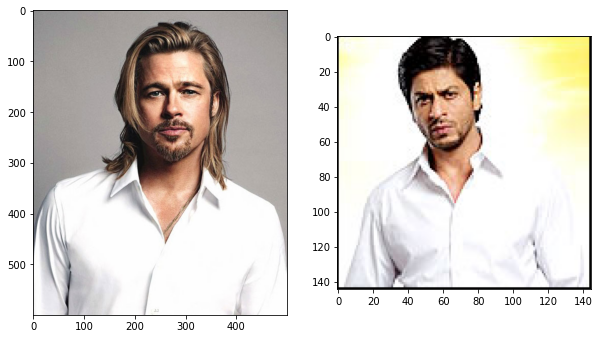

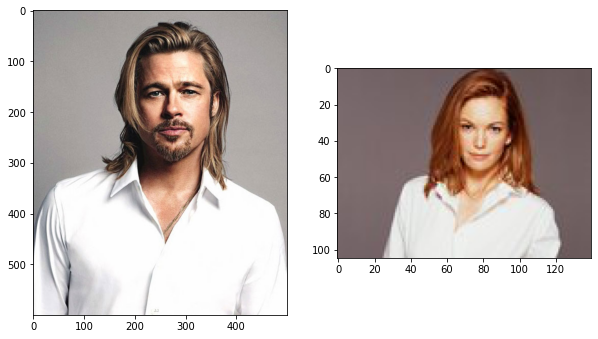

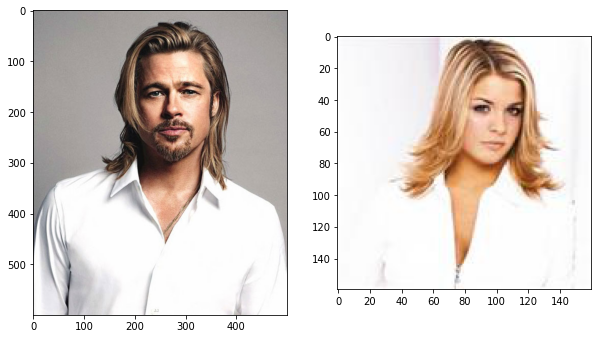

In [ ]:
retrieval(loaded_mobilenet['paths'], '/content/gdrive/MyDrive/DSIM/Brad_Pitt2.jpg', tree_mobilenet, mobilenet, mobilenet_v2.preprocess_input,3)

Sembra che le features permettano di riconoscere le immagini simili in termini di look e scena

Query sulle features estratte con VGG Face

/content/thumbnails_features_deduped_publish/anne hathaway/753.jpg
/content/thumbnails_features_deduped_publish/katrina kaif/658.jpg
/content/thumbnails_features_deduped_publish/bob marley/252.jpg


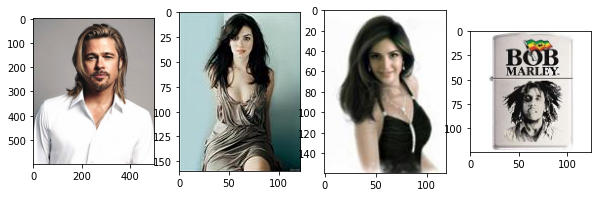

In [ ]:
retrieval(loaded_vggface['paths'], '/content/gdrive/MyDrive/DSIM/Brad_Pitt2.jpg', tree_vggface, vggface, utils.preprocess_input)

I risultati sembrano essere poco precisi: non c'è molta similarità fra la query e le immagini restituite

#Cropped dataset

Si utilizza MTCNN per estrarre i bounding box che contengono i volti presenti nelle immagini in modo tale da identificare i soggetti con volto simile (evitando che le features siano troppo descrittive del contesto)

##Cropping

Memorizzazione degli array che rappresentano le immagini ritagliate

In [ ]:
detector = MTCNN()
cropped_images, paths = cropp_data(limit = 10, cropping = face_cropper_mtcnn, detector = detector)
np.savez_compressed('cropped_images', cropped_images = cropped_images, paths = paths)
!cp cropped_images.npz '/content/gdrive/MyDrive/DSIM/image_retrieval'

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
shutil.copyfile('/content/drive/MyDrive/DSIM/image_retrieval/cropped_images.npz', 'cropped_images.npz')

'cropped_images.npz'

In [ ]:
loaded_cropped = np.load('cropped_images.npz', allow_pickle = True)

Alcuni test su foto particolari.

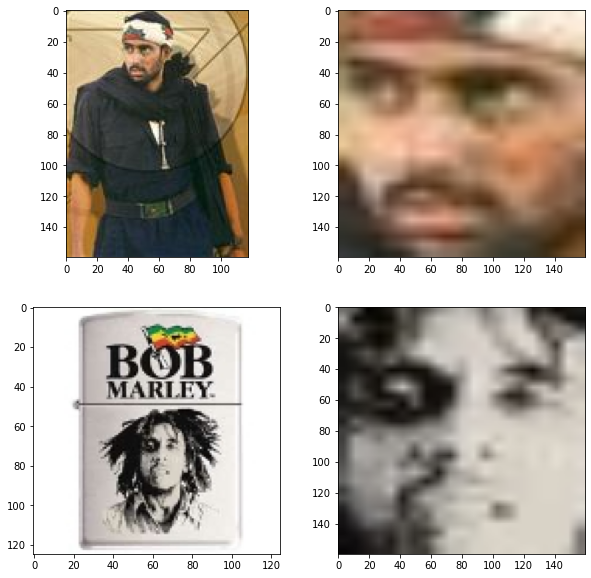

In [ ]:
test_img0 = cv2.imread('/content/thumbnails_features_deduped_publish/abhishek bachchan/110.jpg')
test_img1 = cv2.imread('/content/thumbnails_features_deduped_publish/bob marley/252.jpg')
test_img0 = cv2.cvtColor(test_img0, cv2.COLOR_BGR2RGB)
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
cropped0 = face_cropper_mtcnn(test_img0, target_size = (160, 160), detector = detector)[0]
cropped1 = face_cropper_mtcnn(test_img1, target_size = (160, 160), detector = detector)[0]
display_img([test_img0, cropped0, test_img1, cropped1],nrow = 2, ncol = 2)

###Mobilenet

Mobilenet sulle immagini ritagliate

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                     pooling='max', input_shape=(160, 160, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# estrazione delle features
features_mobilenet, cropped_path_mobilenet, fail_paths_mobilenet = features_cropped_images(
    loaded_cropped['cropped_images'].tolist(),
    loaded_cropped['paths'],
    mobilenet,
    prep_fun = mobilenet_v2.preprocess_input,
    target_size = (160, 160)
    )

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
concatenazione
preprocessing
previsioni


In [ ]:
tree_mobilenet = KDTree(features_mobilenet)

Test su una immagine di Lebron James

0
/content/thumbnails_features_deduped_publish/lebron james/76.jpg
/content/thumbnails_features_deduped_publish/vince vaughn/103.jpg
/content/thumbnails_features_deduped_publish/poppy montgomery/39.jpg


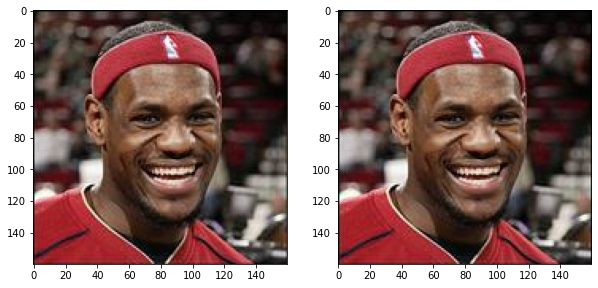

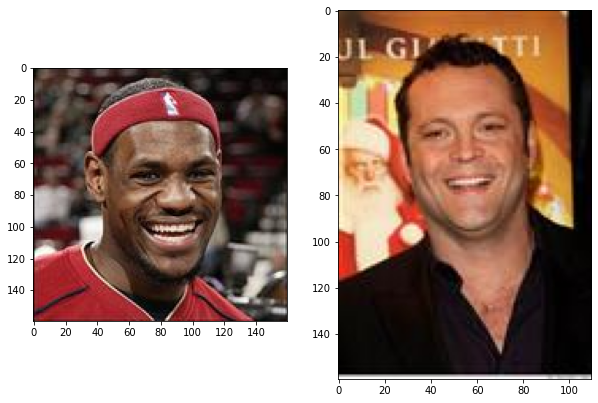

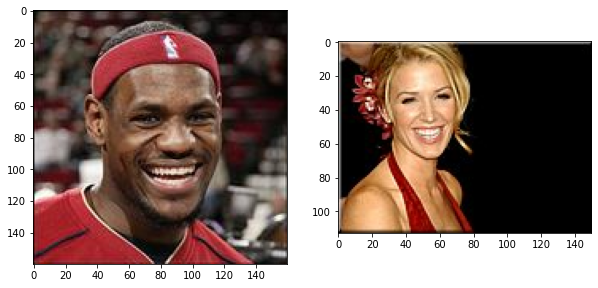

In [ ]:
detector = MTCNN()
retrieval_cropping(
    cropped_path_mobilenet,
    '/content/thumbnails_features_deduped_publish/lebron james/76.jpg',
    #'/content/lebron_james2.jpeg',#'/content/thumbnails_features_deduped_publish/robert downey/25.jpg',
    tree_mobilenet,
    mobilenet,
    prep_function = mobilenet_v2.preprocess_input,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

Sembra che abbia restituito immagini con espressione del volto simile (es. sorriso, sopracciglia, ...)

###FaceNet

In [ ]:
shutil.copyfile('/content/drive/MyDrive/DSIM/image_retrieval/facenet_keras.h5', 'facenet_keras.h5')
#shutil.copyfile('/content/gdrive/MyDrive/DSIM/image_retrieval/facenet_keras_weights.h5', 'facenet_keras_weights.h5')

'facenet_keras.h5'

In [ ]:
# model summary

facenet_base = load_model('facenet_keras.h5')
get_model_summary(
    facenet_base,
    [i for i in range(len(facenet_base.layers))]
    #[0] + sorted(-j for j in range(1,5))
    )

Layer name	 Output shape
input_1 	 [(None, 160, 160, 3)]
Conv2d_1a_3x3 	 (None, 79, 79, 32)
Conv2d_1a_3x3_BatchNorm 	 (None, 79, 79, 32)
Conv2d_1a_3x3_Activation 	 (None, 79, 79, 32)
Conv2d_2a_3x3 	 (None, 77, 77, 32)
Conv2d_2a_3x3_BatchNorm 	 (None, 77, 77, 32)
Conv2d_2a_3x3_Activation 	 (None, 77, 77, 32)
Conv2d_2b_3x3 	 (None, 77, 77, 64)
Conv2d_2b_3x3_BatchNorm 	 (None, 77, 77, 64)
Conv2d_2b_3x3_Activation 	 (None, 77, 77, 64)
MaxPool_3a_3x3 	 (None, 38, 38, 64)
Conv2d_3b_1x1 	 (None, 38, 38, 80)
Conv2d_3b_1x1_BatchNorm 	 (None, 38, 38, 80)
Conv2d_3b_1x1_Activation 	 (None, 38, 38, 80)
Conv2d_4a_3x3 	 (None, 36, 36, 192)
Conv2d_4a_3x3_BatchNorm 	 (None, 36, 36, 192)
Conv2d_4a_3x3_Activation 	 (None, 36, 36, 192)
Conv2d_4b_3x3 	 (None, 17, 17, 256)
Conv2d_4b_3x3_BatchNorm 	 (None, 17, 17, 256)
Conv2d_4b_3x3_Activation 	 (None, 17, 17, 256)
Block35_1_Branch_2_Conv2d_0a_1x1 	 (None, 17, 17, 32)
Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm 	 (None, 17, 17, 32)
Block35_1_Branch_2_Conv2d_0

In [ ]:
facenet = Model(inputs = facenet_base.inputs, outputs = facenet_base.get_layer('AvgPool').output)
get_model_summary(
    facenet,
    [0] + sorted(-j for j in range(1,5))
    )

Layer name	 Output shape
input_1 	 [(None, 160, 160, 3)]
Block8_6_Concatenate 	 (None, 3, 3, 384)
Block8_6_Conv2d_1x1 	 (None, 3, 3, 1792)
Block8_6_ScaleSum 	 (None, 3, 3, 1792)
AvgPool 	 (None, 1792)


Preprocessing di facenet: standardizzazione across channels

In [ ]:
def facenet_preprocessing(img):
  mean, std = img.mean(), img.std()
  img = (img - mean) / std
  return img

Estrazione delle features e generazione del KD Tree

In [ ]:
K.set_floatx('float16')

In [ ]:
features_facenet, cropped_path_facenet, fail_paths_facenet = features_cropped_images(
    loaded_cropped['cropped_images'].tolist(),
    loaded_cropped['paths'],
    facenet,
    facenet_preprocessing,
    target_size = (160, 160))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


In [ ]:
np.savez_compressed(
    'features_facenet_cropped2',
    features_facenet = features_facenet,
    cropped_path_facenet = cropped_path_facenet
    )

In [ ]:
!cp features_facenet_cropped2.npz '/content/drive/MyDrive/DSIM/image_retrieval'

In [ ]:
shutil.copyfile('/content/drive/MyDrive/DSIM/image_retrieval/features_facenet_cropped2.npz',
         'features_facenet_cropped2.npz')

'features_facenet_cropped2.npz'

In [ ]:
features_facenet_cropped = np.load('/content/drive/MyDrive/DSIM/image_retrieval/features_facenet_cropped2.npz')

In [ ]:
# Creazione del KDTree
tree_facenet = KDTree(features_facenet_cropped['features_facenet'])

In [ ]:
cropped_path_facenet = features_facenet_cropped['cropped_path_facenet']

/content/thumbnails_features_deduped_publish/alicia silverstone/79.jpg
0
[[ 950 8427  949]]
/content/thumbnails_features_deduped_publish/alicia silverstone/79.jpg
0.00017756150648242833
/content/thumbnails_features_deduped_publish/emily deschanel/10.jpg
11.840982362842167
/content/thumbnails_features_deduped_publish/alicia silverstone/53.jpg
12.154206022702162


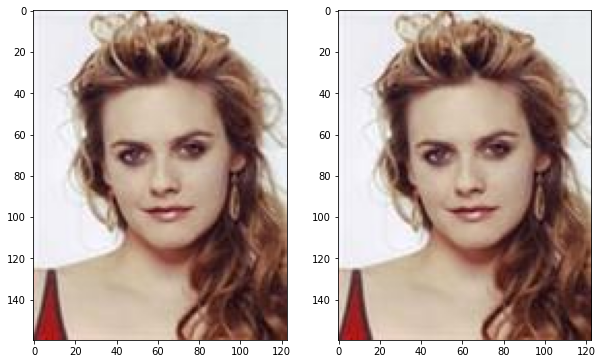

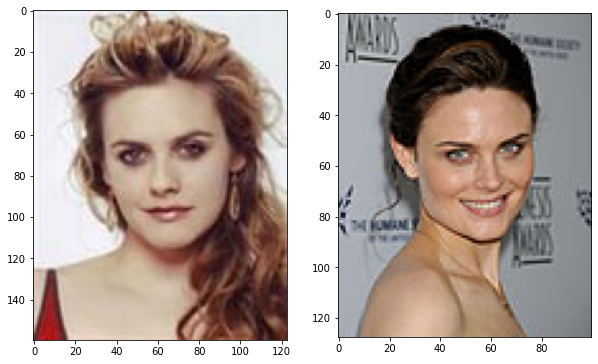

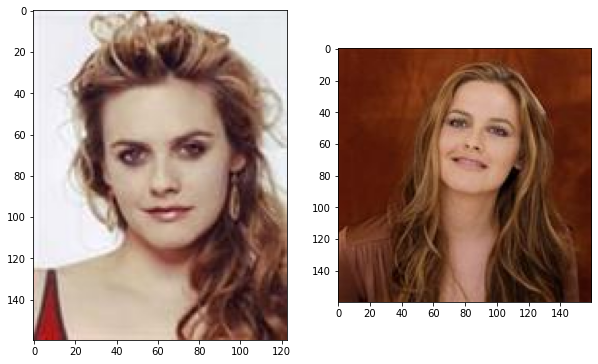

In [ ]:
detector = MTCNN()
retrieval_cropping(
    paths = cropped_path_facenet,
    #'/content/lebron_james2.jpeg',
    query_path = '/content/thumbnails_features_deduped_publish/alicia silverstone/79.jpg',
    tree = tree_facenet,
    net = facenet,
    prep_function = facenet_preprocessing,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

/content/thumbnails_features_deduped_publish/robert downey/190.jpg
0
[[24234 24237 24245]]
/content/thumbnails_features_deduped_publish/robert downey/190.jpg
0.0005908051356725139
/content/thumbnails_features_deduped_publish/robert downey/25.jpg
11.259609725896023
/content/thumbnails_features_deduped_publish/robert downey/95.jpg
12.585879870156317


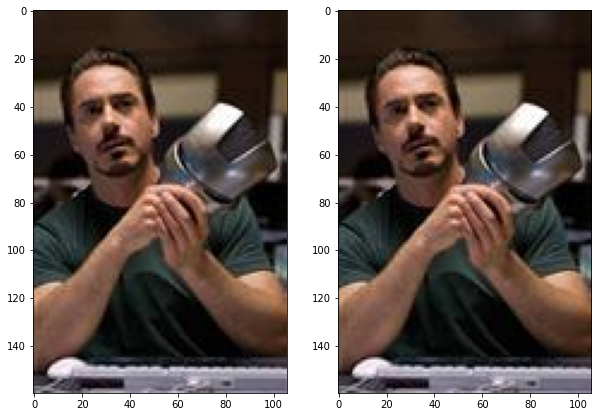

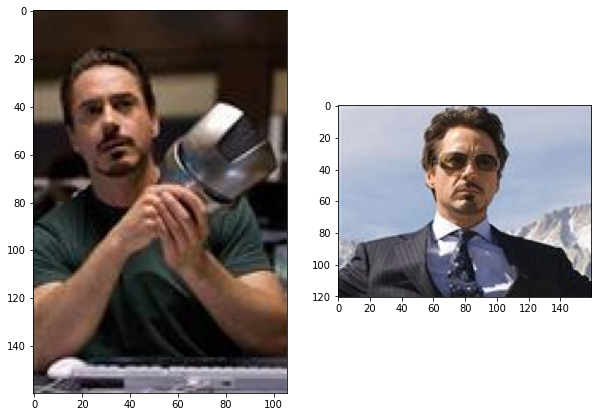

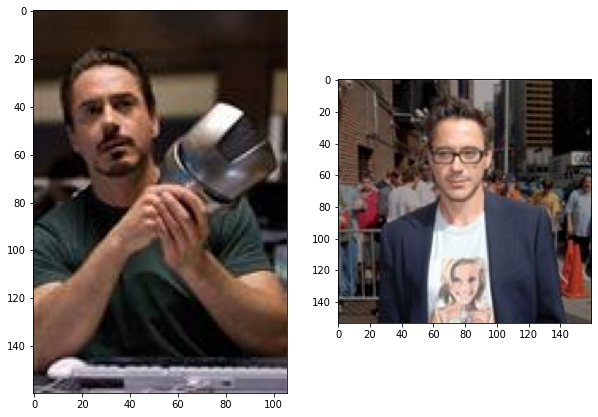

In [ ]:
detector = MTCNN()
retrieval_cropping(
    paths = cropped_path_facenet,
    #'/content/lebron_james2.jpeg',
    query_path = '/content/thumbnails_features_deduped_publish/robert downey/190.jpg',
    tree = tree_facenet,
    net = facenet,
    prep_function = facenet_preprocessing,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

download.jpeg
0
[[24244 24231 24228]]
/content/thumbnails_features_deduped_publish/robert downey/87.jpg
9.204953392012259
/content/thumbnails_features_deduped_publish/robert downey/141.jpg
9.26816691959201
/content/thumbnails_features_deduped_publish/robert downey/11.jpg
9.912362325502192


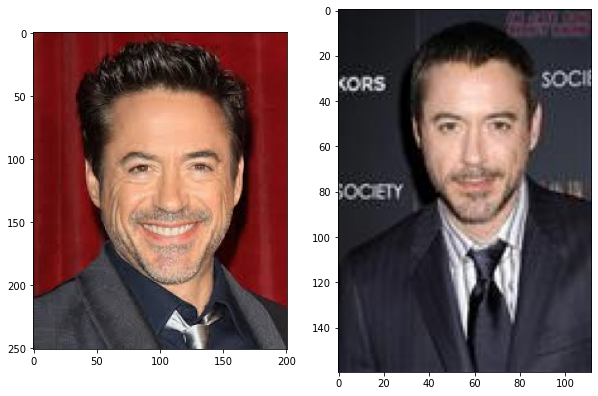

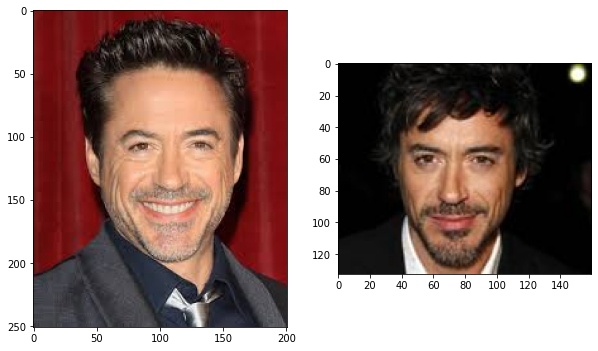

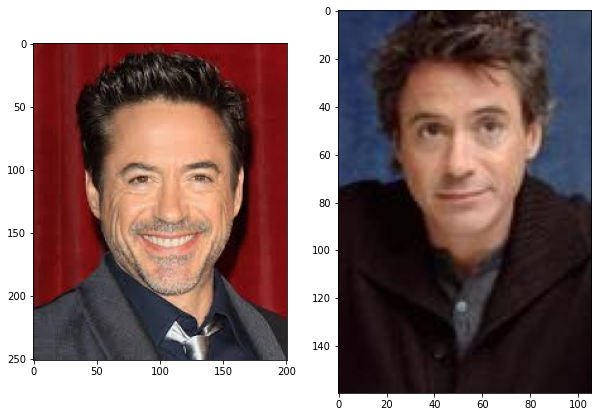

In [ ]:
detector = MTCNN()
retrieval_cropping(
    paths = cropped_path_facenet,
    query_path = 'download.jpeg',
    #query_path = '/content/thumbnails_features_deduped_publish/robert downey/190.jpg',
    tree = tree_facenet,
    net = facenet,
    prep_function = facenet_preprocessing,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

# Retrieval su mobilenet fine-tuned.

Si prova ad addestrare una rete per la previsione dell'identità del personaggio nella foto, per fare in modo che vengano estratte features adeguate al nostro task su cui fare il retrieval.

In [ ]:
shutil.copyfile('/content/gdrive/MyDrive/DSIM/image_retrieval/cropped_images.npz', 'cropped_images.npz')
loaded_cropped = np.load('cropped_images.npz', allow_pickle = True)

In [ ]:
K.set_floatx('float16')
K.clear_session()

In [ ]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                     pooling='max', input_shape=(96, 96, 3))

In [ ]:
is_trainable = False
for layer in mobilenet.layers:
  if layer.name == 'block_12_add': 
    is_trainable = True
  layer.trainable = is_trainable
  

In [ ]:
mobilenet.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [ ]:
# Preprocessing
preprocessed_mobilenet, path_mobnet, fails_mobnet = features_cropped_images(
    loaded_cropped['cropped_images'],
    loaded_cropped['paths'],
    net = None,
    prep_fun = keras.applications.mobilenet_v2.preprocess_input,
    target_size = (96, 96))

In [ ]:
# Categorizzazione delle labels

classes = [x.split('/')[-2] for x in path_mobnet]
n_classes = np.unique(classes).shape[0]

lb = LabelBinarizer()
lb.fit(classes)
y = lb.transform(classes)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# Creazione del modello

mod = keras.models.Sequential(
    [
     mobilenet,
     layers.Dense(n_classes, activation = 'softmax')
    ]

)

In [ ]:
mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1580)              2023980   
Total params: 4,281,964
Trainable params: 3,705,324
Non-trainable params: 576,640
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_mobilenet, y, test_size = 0.1)

In [ ]:
mod.compile(
      optimizer = 'adamax',#optimizers.Adamax(learning_rate = .01),
      loss = 'categorical_crossentropy', 
      metrics = ['accuracy'])

mod.fit(
        X_train, y_train,
        validation_data = (X_test, y_test),
        epochs=25,
        batch_size = 32
        )

Epoch 1/25
833/833 [==============================] - 19s 11ms/step - loss: inf - accuracy: 0.0013 - val_loss: 7.5234 - val_accuracy: 0.0017
Epoch 2/25
833/833 [==============================] - 9s 10ms/step - loss: inf - accuracy: 0.0016 - val_loss: 7.3828 - val_accuracy: 0.0027
Epoch 3/25
833/833 [==============================] - 8s 10ms/step - loss: inf - accuracy: 0.0040 - val_loss: 7.1719 - val_accuracy: 0.0027
Epoch 4/25
833/833 [==============================] - 9s 10ms/step - loss: inf - accuracy: 0.0096 - val_loss: 6.9766 - val_accuracy: 0.0057
Epoch 5/25
833/833 [==============================] - 9s 10ms/step - loss: inf - accuracy: 0.0198 - val_loss: 6.7422 - val_accuracy: 0.0118
Epoch 6/25
833/833 [==============================] - 9s 10ms/step - loss: inf - accuracy: 0.0382 - val_loss: 6.8203 - val_accuracy: 0.0149
Epoch 7/25
833/833 [==============================] - 9s 10ms/step - loss: inf - accuracy: 0.0673 - val_loss: 6.7148 - val_accuracy: 0.0203
Epoch 8/25
833/833 

Nonostante siano stati svolti vari tentativi, nessun modello riesce a generalizzare e di conseguenza manifesta overfitting. Questo potrebbe essere dovuto al fatto che per effettuare il cropping dell'immagine è stato necessario campionare il dataset iniziale. Con l'intero dataset di partenza, il problema potrebbe essere risolto.